The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_temp/convergence_analysis_s18/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


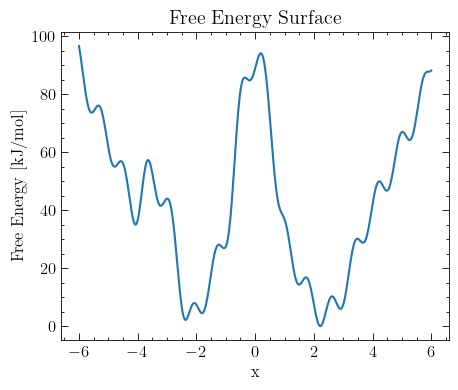

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_temp/convergence_analysis_s18/"): print("\nThe data folder \"_data_temp/convergence_analysis_s18/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis_s18/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis_s18/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 18
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

#### Define default parameters

In [12]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [2]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, #"dy":dy, # "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 1_000_000, 
					"position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":3, "biasfactor":60 , 
         			"Bias_sf":1, "gaus_filter_sigma":None, 
                    "len_error_list":100, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True, "save_error_progression":True,
     				"simulation_folder_path": path_data, "print_info": False}

### Run Long simulation for reference

In [14]:
# Run 100 long simulations
long_sim_params = {**default_params}

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,31):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class1D.MFI1D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index]
                
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, (AAD at 10% = {aad[10]:.4f})")
    if i_sim % 5 == 0: 
        aad_avr = np.mean(aad_collection, axis=0)
        print(f"--- Mean of final AAD: {aad_avr[-1]:.4f}, (10% = {aad_avr[10]:.4f})")       



Simulation 1 (exists) | Final Error: Aofe = 1.7635, AAD = 0.6746, (AAD at 10% = 1.9120)
Simulation 2 (exists) | Final Error: Aofe = 1.7323, AAD = 0.4650, (AAD at 10% = 2.0219)
Simulation 3 (exists) | Final Error: Aofe = 1.7299, AAD = 0.8911, (AAD at 10% = 3.9814)
Simulation 4 (exists) | Final Error: Aofe = 1.7442, AAD = 0.4619, (AAD at 10% = 4.2837)
Simulation 5 (exists) | Final Error: Aofe = 1.6872, AAD = 0.7407, (AAD at 10% = 4.3771)
--- Mean of final AAD: 0.6467, (10% = 3.3152)
Simulation 6 (exists) | Final Error: Aofe = 1.7177, AAD = 0.5488, (AAD at 10% = 4.3774)
Simulation 7 (exists) | Final Error: Aofe = 1.7223, AAD = 0.7667, (AAD at 10% = 3.2976)
Simulation 8 (exists) | Final Error: Aofe = 1.7084, AAD = 0.6683, (AAD at 10% = 1.6981)
Simulation 9 (exists) | Final Error: Aofe = 1.7618, AAD = 0.8966, (AAD at 10% = 3.8659)
Simulation 10 (exists) | Final Error: Aofe = 1.7208, AAD = 1.1855, (AAD at 10% = 3.3853)
--- Mean of final AAD: 0.7299, (10% = 3.3201)
Simulation 11 | Final Error

Mean Final AAD: 0.7299 +- 0.0667


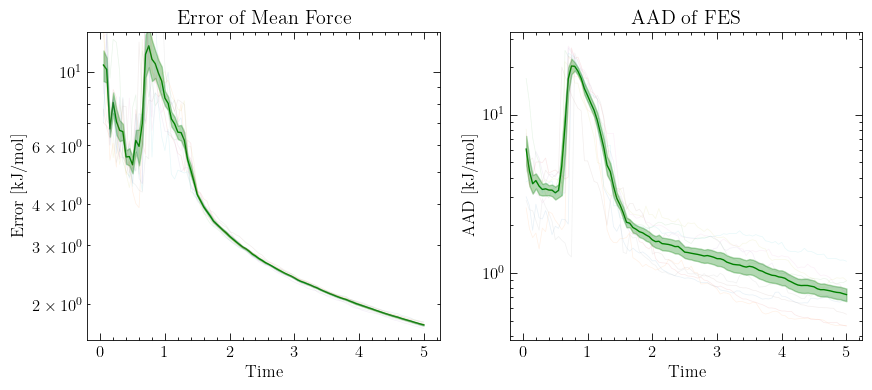

In [4]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=True)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f}")
plt.show()


### Exploration simulation

In [5]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":100_000, "metad_height":5, "metad_width":0.2, "biasfactor":600, "len_error_list":25})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class1D.MFI1D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")       


Simulation 1 (exists) | Final Error: Aofe = 5.5352, AAD = 3.2344
Simulation 2 (exists) | Final Error: Aofe = 5.9472, AAD = 3.4201
Simulation 3 (exists) | Final Error: Aofe = 5.7655, AAD = 1.9664
Simulation 4 (exists) | Final Error: Aofe = 5.7503, AAD = 3.5544
Simulation 5 (exists) | Final Error: Aofe = 5.8910, AAD = 2.3768
--- Mean of final AAD: 2.9104
Simulation 6 (exists) | Final Error: Aofe = 5.6683, AAD = 2.4187
Simulation 7 (exists) | Final Error: Aofe = 5.4671, AAD = 2.4437
Simulation 8 (exists) | Final Error: Aofe = 5.5607, AAD = 3.5388
Simulation 9 (exists) | Final Error: Aofe = 5.9310, AAD = 3.1962
Simulation 10 (exists) | Final Error: Aofe = 5.5693, AAD = 2.7734
--- Mean of final AAD: 2.8923
Simulation 11 (exists) | Final Error: Aofe = 5.7117, AAD = 2.0223
Simulation 12 (exists) | Final Error: Aofe = 5.6504, AAD = 3.6340
Simulation 13 (exists) | Final Error: Aofe = 5.7941, AAD = 2.3924
Simulation 14 (exists) | Final Error: Aofe = 5.8404, AAD = 2.8151
Simulation 15 (exists) | 

Mean Final AAD: 3.0429 +- 0.0735


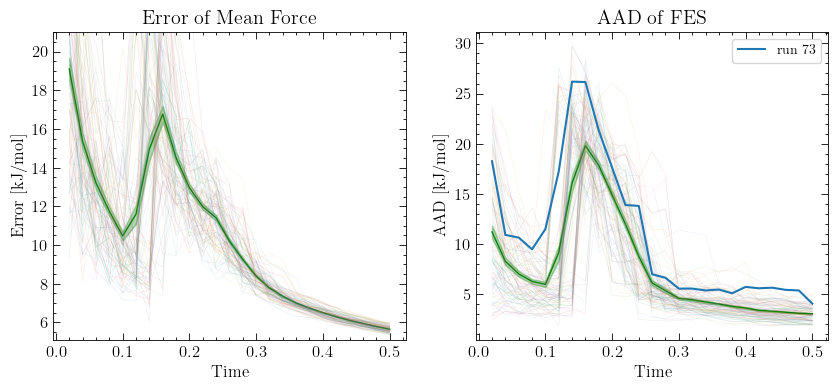

In [6]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

plt.plot(t, aad_collection[37-1], label="run 73")
plt.legend(fontsize=10)
plt.show()


In [25]:
# # Plot all exploration simulations to find a representative one to use for metad stage
# t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
# t = t_collection[0]

# for j in range(1, 21):
    
#     time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=False)
#     plt.subplot(1,2,1) 
#     for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
#     plt.subplot(1,2,2)
#     for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)    
    
#     for jj in range((j-1)*5, (j)*5):
        
#         print(f"Simulation {jj+1}", end=" | ")
        
#         plt.subplot(1,2,1)
#         plt.plot(t, aofe_collection[jj], label=f"{jj+1}", alpha=0.5)
#         plt.subplot(1,2,2)
#         plt.plot(t, aad_collection[jj], label=f"{jj+1}", alpha=0.5)
    
#     print("")    
#     plt.legend(fontsize=10)
#     plt.yscale("log")
#     plt.show() 
                                                                                                        

Final Error: Aofe = 5.8016, AAD = 3.0217
MIN(FES+Bias) = 107.3466, MIN(Z+Bias) = 116.8224


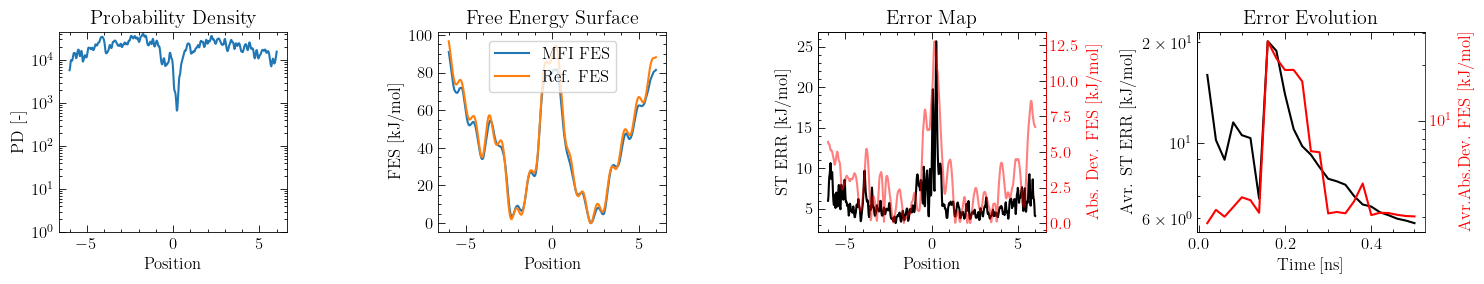

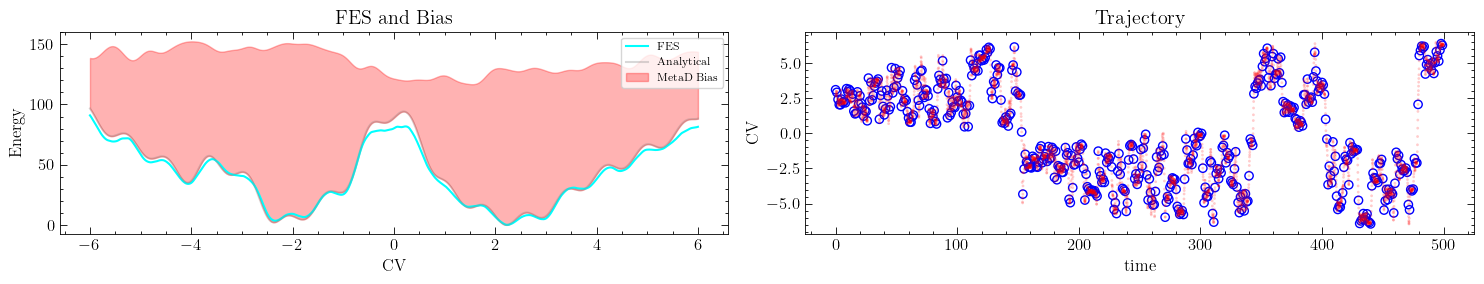

In [15]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
# new_params.update({"ID":"_expl_test", "len_error_list":25})
# new_params.update({"simulation_steps": 100_000, "metad_height":5, "metad_width":0.2, "biasfactor":600})
new_params.update({"save_error_progression":False, "save_force_terms":False})
new_params.update({"ID":"_expl_94", "len_error_list":25})

MFI_expl = MFI_class1D.MFI1D(**new_params)
# MFI_expl.run_simulation()   ########################
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(MFI_expl.y + MFI_expl.Bias):.4f}")
MFI_expl.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI_expl.grid, fes=MFI_expl.FES, metad_bias=MFI_expl.Bias, position=MFI_expl.position, hills=MFI_expl.hills, y=MFI_expl.y )
t_expl, v_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES


### 2nd Stage - Run MetaD simulation

In [27]:
# # test metad simulation

# metad_sim_params = {**default_params}
# metad_sim_params.update({"simulation_steps":900_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
# metad_sim_params.update({"biasfactor":10})#, "Bias_sf":1.03, "gaus_filter_sigma":2})
# metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})

# i_sim = 9
# # sim_ID = f"_metad_{i_sim}"
# sim_ID = f"_metad_test"
# metad_sim_params.update({"ID":sim_ID})

# MFI_metad = MFI_class1D.MFI1D(**metad_sim_params)
# MFI_metad.make_external_bias(FES=fes_expl)
# MFI_metad.run_simulation()
# MFI_metad.analyse_data()

# MFI_metad.plot_results()
# lib1.plot_FES_Bias_and_Traj(grid=MFI_metad.grid, fes=MFI_metad.FES, metad_bias=MFI_metad.Bias, static_bias=MFI_metad.Bias_static, position=MFI_metad.position, hills=MFI_metad.hills, y=MFI_metad.y )

# plt.figure(figsize=(10,10))

# plt.plot(grid, MFI_metad.FES, label="FES");


In [16]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":900_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
metad_sim_params.update({"biasfactor":10})#, "Bias_sf":1, "gaus_filter_sigma":None})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class1D.MFI1D(**metad_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): 
            MFI_metad.make_external_bias(FES=fes_expl)
            MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.5389, AAD = 0.4746
Simulation 2 (exists) | Final Error: Aofe = 1.5295, AAD = 0.3756
Simulation 3 (exists) | Final Error: Aofe = 1.5342, AAD = 0.3707
Simulation 4 (exists) | Final Error: Aofe = 1.5294, AAD = 0.4861
Simulation 5 (exists) | Final Error: Aofe = 1.5537, AAD = 0.4535
--- Mean of final AAD: 0.4321
Simulation 6 (exists) | Final Error: Aofe = 1.5297, AAD = 0.4528
Simulation 7 (exists) | Final Error: Aofe = 1.5376, AAD = 0.4438
Simulation 8 (exists) | Final Error: Aofe = 1.5254, AAD = 0.3853
Simulation 9 (exists) | Final Error: Aofe = 1.5571, AAD = 0.3915
Simulation 10 (exists) | Final Error: Aofe = 1.5350, AAD = 0.5737
--- Mean of final AAD: 0.4408
Simulation 11 (exists) | Final Error: Aofe = 1.5286, AAD = 0.4870
Simulation 12 (exists) | Final Error: Aofe = 1.5465, AAD = 0.4370
Simulation 13 (exists) | Final Error: Aofe = 1.5376, AAD = 0.4486
Simulation 14 (exists) | Final Error: Aofe = 1.5339, AAD = 0.3714
Simulation 15 (exists) | 

Mean Final AAD: 0.4556 +- 0.0076


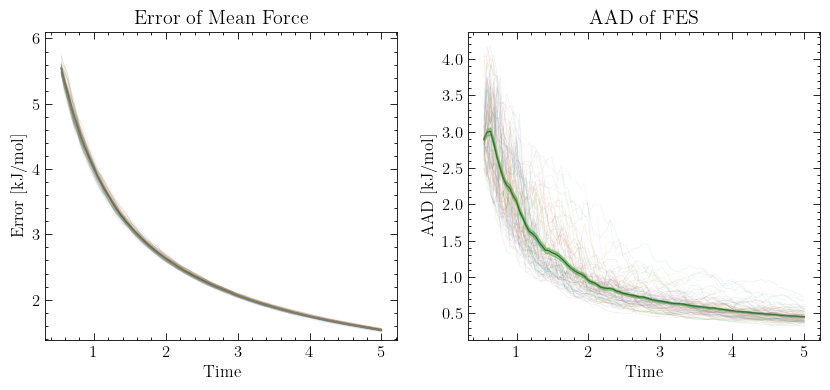

In [17]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f}")
plt.show()

### 2nd Stage - Run 2x MetaD simulations

In [18]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class1D.MFI1D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, aofe, aad = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.2771, AAD = 0.3958
Analysis 2 | Final Error: Aofe = 1.2791, AAD = 0.4057
Analysis 3 | Final Error: Aofe = 1.2905, AAD = 0.5775
Analysis 4 | Final Error: Aofe = 1.2748, AAD = 0.3525
Analysis 5 | Final Error: Aofe = 1.2798, AAD = 0.3935
Analysis 6 | Final Error: Aofe = 1.2891, AAD = 0.3894
Analysis 7 | Final Error: Aofe = 1.2762, AAD = 0.4065
Analysis 8 | Final Error: Aofe = 1.2751, AAD = 0.3986
Analysis 9 | Final Error: Aofe = 1.2850, AAD = 0.4424
Analysis 10 | Final Error: Aofe = 1.2784, AAD = 0.4894
Analysis 11 | Final Error: Aofe = 1.2854, AAD = 0.4696
Analysis 12 | Final Error: Aofe = 1.2747, AAD = 0.3894
Analysis 13 | Final Error: Aofe = 1.2749, AAD = 0.3434
Analysis 14 | Final Error: Aofe = 1.2613, AAD = 0.4313
Analysis 15 | Final Error: Aofe = 1.2806, AAD = 0.4807
Analysis 16 | Final Error: Aofe = 1.2799, AAD = 0.3700
Analysis 17 | Final Error: Aofe = 1.2882, AAD = 0.5409
Analysis 18 | Final Error: Aofe = 1.2802, AAD = 0.3592
Analysis 19 | Final

Mean Final AAD: 0.4227 +- 0.0090


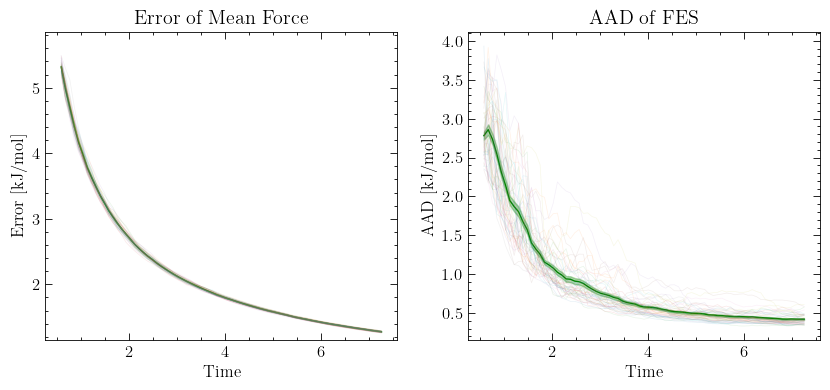

In [19]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f}")
plt.show()

### 2nd Stage - Run 3x MetaD simulations

In [102]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1);

In [20]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class1D.MFI1D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.1236, AAD = 0.3273
Analysis 2 | Final Error: Aofe = 1.1260, AAD = 0.4016
Analysis 3 | Final Error: Aofe = 1.1258, AAD = 0.3389
Analysis 4 | Final Error: Aofe = 1.1259, AAD = 0.3988
Analysis 5 | Final Error: Aofe = 1.1168, AAD = 0.3212
Analysis 6 | Final Error: Aofe = 1.1257, AAD = 0.3750
Analysis 7 | Final Error: Aofe = 1.1297, AAD = 0.5044
Analysis 8 | Final Error: Aofe = 1.1234, AAD = 0.3674
Analysis 9 | Final Error: Aofe = 1.1107, AAD = 0.3156
Analysis 10 | Final Error: Aofe = 1.1197, AAD = 0.3467
Analysis 11 | Final Error: Aofe = 1.1240, AAD = 0.3105
Analysis 12 | Final Error: Aofe = 1.1299, AAD = 0.4976
Analysis 13 | Final Error: Aofe = 1.1098, AAD = 0.5549
Analysis 14 | Final Error: Aofe = 1.1313, AAD = 0.3540
Analysis 15 | Final Error: Aofe = 1.1210, AAD = 0.3821
Analysis 16 | Final Error: Aofe = 1.1246, AAD = 0.4058
Analysis 17 | Final Error: Aofe = 1.1177, AAD = 0.3951
Analysis 18 | Final Error: Aofe = 1.1108, AAD = 0.3848
Analysis 19 | Final

Mean Final AAD: 0.3803 +- 0.0100


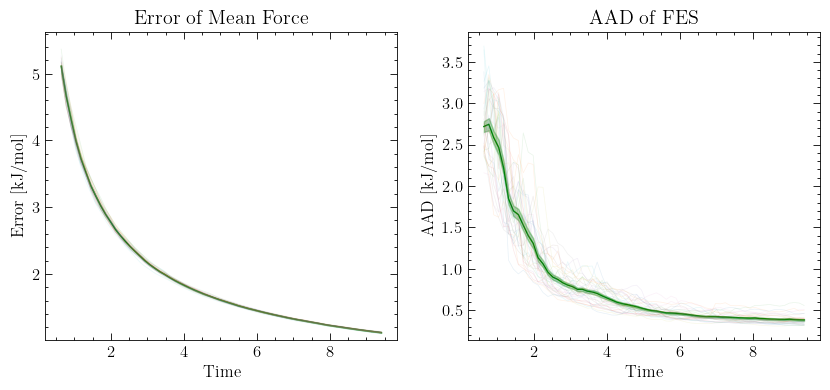

In [21]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - Run 4x MetaD simulations

In [22]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class1D.MFI1D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 | Final Error: Aofe = 1.1297, AAD = 0.3792
Analysis 2 | Final Error: Aofe = 1.1364, AAD = 0.3688
Analysis 3 | Final Error: Aofe = 1.1415, AAD = 0.3729
Analysis 4 | Final Error: Aofe = 1.1258, AAD = 0.3223
Analysis 5 | Final Error: Aofe = 1.1429, AAD = 0.3713
Analysis 6 | Final Error: Aofe = 1.1349, AAD = 0.3718
Analysis 7 | Final Error: Aofe = 1.1236, AAD = 0.3199
Analysis 8 | Final Error: Aofe = 1.1384, AAD = 0.4086
Analysis 9 | Final Error: Aofe = 1.1426, AAD = 0.6003
Analysis 10 | Final Error: Aofe = 1.1286, AAD = 0.4037
Analysis 11 | Final Error: Aofe = 1.1288, AAD = 0.3438
Analysis 12 | Final Error: Aofe = 1.1352, AAD = 0.3860
Analysis 13 | Final Error: Aofe = 1.1270, AAD = 0.4613
Analysis 14 | Final Error: Aofe = 1.1152, AAD = 0.4435
Analysis 15 | Final Error: Aofe = 1.1343, AAD = 0.3278
Analysis 16 | Final Error: Aofe = 1.1405, AAD = 0.3637
Analysis 17 | Final Error: Aofe = 1.1237, AAD = 0.3713
Analysis 18 | Final Error: Aofe = 1.1321, AAD = 0.3436
Analysis 19 | Final

Mean Final AAD: 0.3904 +- 0.0127


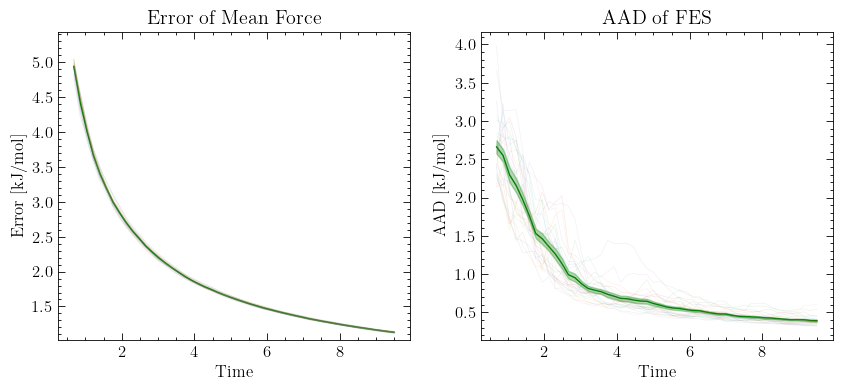

In [23]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [24]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class1D.MFI1D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.0443, AAD = 0.3409
Analysis 2 | Final Error: Aofe = 1.0533, AAD = 0.4339
Analysis 3 | Final Error: Aofe = 1.0466, AAD = 0.3268
Analysis 4 | Final Error: Aofe = 1.0513, AAD = 0.4512
Analysis 5 | Final Error: Aofe = 1.0415, AAD = 0.3597
Analysis 6 | Final Error: Aofe = 1.0538, AAD = 0.3793
Analysis 7 | Final Error: Aofe = 1.0448, AAD = 0.3317
Analysis 8 | Final Error: Aofe = 1.0430, AAD = 0.4132
Analysis 9 | Final Error: Aofe = 1.0359, AAD = 0.4225
Analysis 10 | Final Error: Aofe = 1.0485, AAD = 0.3672
Analysis 11 | Final Error: Aofe = 1.0541, AAD = 0.3729
Analysis 12 | Final Error: Aofe = 1.0446, AAD = 0.3663
Analysis 13 | Final Error: Aofe = 1.0454, AAD = 0.3436
Analysis 14 | Final Error: Aofe = 1.0444, AAD = 0.3322
Analysis 15 | Final Error: Aofe = 1.0355, AAD = 0.3695
Analysis 16 | Final Error: Aofe = 1.0424, AAD = 0.4218


Mean Final AAD: 0.3803 +- 0.0100


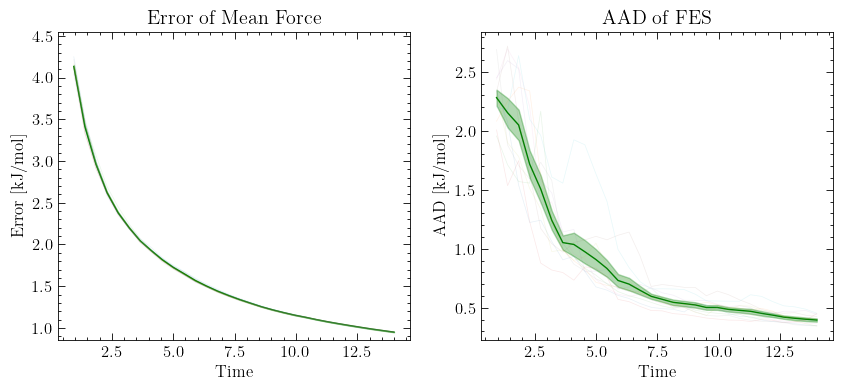

In [26]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [25]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class1D.MFI1D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 0.9542, AAD = 0.3488
Analysis 2 | Final Error: Aofe = 0.9544, AAD = 0.4035
Analysis 3 | Final Error: Aofe = 0.9471, AAD = 0.3762
Analysis 4 | Final Error: Aofe = 0.9535, AAD = 0.4512
Analysis 5 | Final Error: Aofe = 0.9503, AAD = 0.4433
Analysis 6 | Final Error: Aofe = 0.9445, AAD = 0.4264
Analysis 7 | Final Error: Aofe = 0.9438, AAD = 0.3667
Analysis 8 | Final Error: Aofe = 0.9531, AAD = 0.3461
Analysis 9 | Final Error: Aofe = 0.9445, AAD = 0.3450
Analysis 10 | Final Error: Aofe = 0.9485, AAD = 0.4538


Mean Final AAD: 0.3803 +- 0.0100


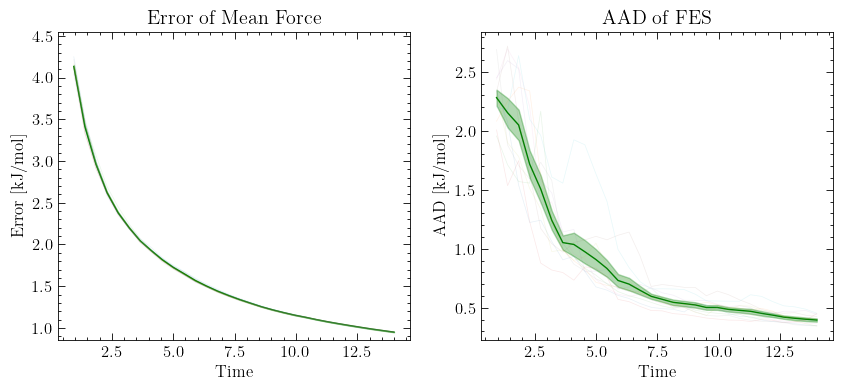

In [27]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [28]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = max(5, int(len(data)/20))    
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data

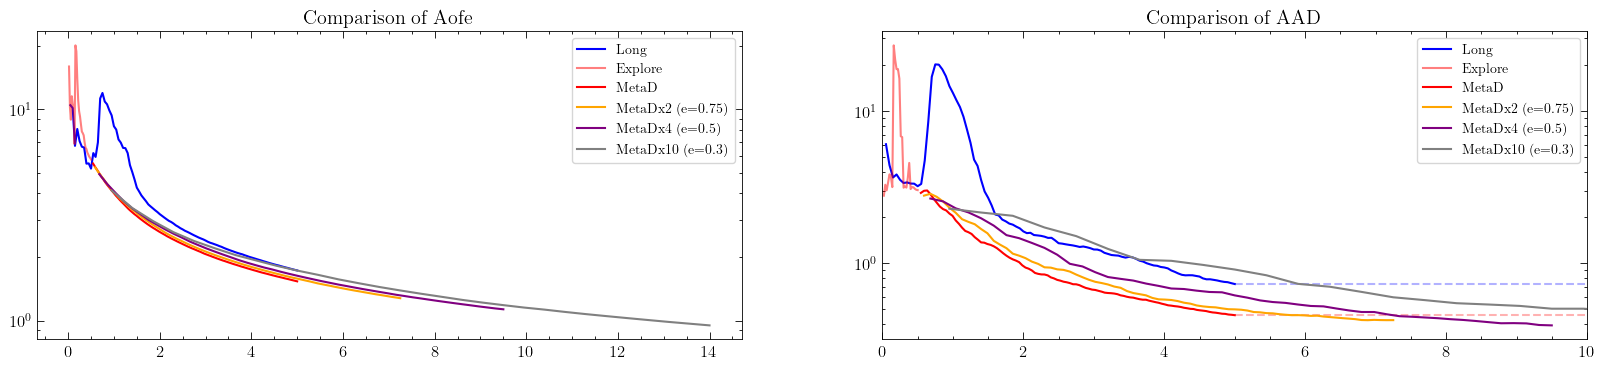

In [32]:
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2 (e=0.75)", color="orange")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3(e=0.67)", color="green")
plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4 (e=0.5)", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6 (e=0.4)", color="aquamarine")
plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx10 (e=0.3)", color="grey")
plt.legend(fontsize=10); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); plt.plot([time_long[-1],10], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red"); plt.plot([time_metad[-1],10], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2 (e=0.75)", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3 (e=0.67)", color="green")
plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4 (e=0.5)", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6 (e=0.4)", color="aquamarine")
plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx10 (e=0.3)", color="grey")

# plt.ylim(0.38, 3)
plt.xlim(0, 10)
plt.yscale("log"); 
plt.legend(fontsize=10); plt.title("Comparison of AAD"); plt.show()

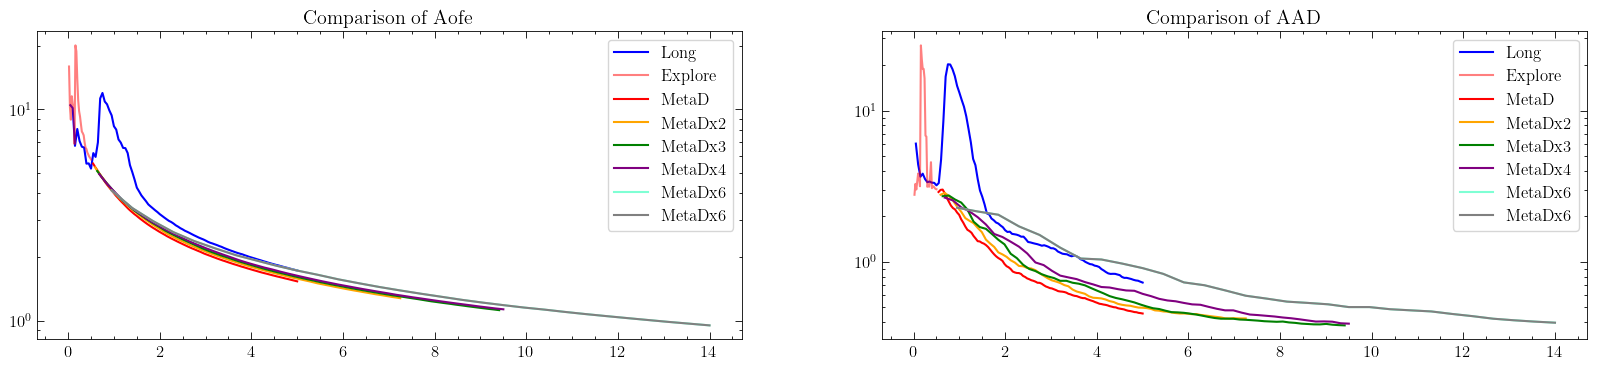

In [31]:
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, mean_aad_long, label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_aad_metad, label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, mean_aad_metadx2, label="MetaDx2", color="orange")
plt.plot(time_metadx3, mean_aad_metadx3, label="MetaDx3", color="green")
plt.plot(time_metadx4, mean_aad_metadx4, label="MetaDx4", color="purple")
plt.plot(time_metadx6, mean_aad_metadx6, label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx6", color="grey")

# plt.ylim(0.38, 0.6)
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()
